In [87]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, BatchNormalization, Dropout, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
!pip install pyvi
from pyvi import ViTokenizer
import pickle
!pip install langdetect
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [88]:
def clean_text(text, is_vietnamese=False):
    text = text.lower()
    if is_vietnamese:
        text = ViTokenizer.tokenize(text)
    else:
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub('\W', ' ', text)
        text = re.sub('\s+', ' ', text)
    return text.strip()

In [89]:
df1 = pd.read_csv('/kaggle/input/toxic-comment-dataset/train.csv')
df2 = pd.read_csv('/kaggle/input/toxic-comment-dataset/youtoxic_english_1000.csv')

print(df1.shape)
print(df2.shape)

(159571, 8)
(1000, 15)


In [90]:
df1['Toxic'] = df1.iloc[:, 2:].any(axis=1).astype(np.int8)
df2['Toxic'] = df2.iloc[:, 3:].any(axis=1).astype(np.int8)

df1_processed = df1[['comment_text', 'Toxic']].rename(columns={'comment_text': 'Text'})
df2_processed = df2[['Text', 'Toxic']]

In [91]:
df_en = pd.concat([df1_processed, df2_processed], ignore_index=True).drop_duplicates(subset=['Text']).reset_index(drop=True)
df_en['Text'] = df_en['Text'].map(lambda x: clean_text(x, is_vietnamese=False))

df_en.shape

(160568, 2)

In [92]:
df_vi = pd.read_csv('/kaggle/input/toxic-comment-dataset/translated_toxic_comment.csv')

print(df_vi.shape)

(159571, 9)


In [93]:
df_vi['Toxic'] = df_vi.iloc[:, 3:].any(axis=1).astype(np.int8)
df_vi_processed = df_vi[['translated_comment_text', 'Toxic']].rename(columns={'translated_comment_text': 'Text'})
df_vi_processed['Text'] = df_vi_processed['Text'].map(lambda x: clean_text(x, is_vietnamese=True))

df_vi_processed.shape

(159571, 2)

In [94]:
df = pd.concat([df_en, df_vi_processed], ignore_index=True).drop_duplicates(subset=['Text']).reset_index(drop=True)

df.shape

(318611, 2)

In [95]:
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 200
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Text'])
sequences = tokenizer.texts_to_sequences(df['Text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                                 padding='post', truncating='post')

X = padded_sequences
y = df['Toxic']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [96]:
print("Class distribution before applying SMOTE:")
print(f"Non-toxic: {sum(y_train == 0)}")
print(f"Toxic: {sum(y_train == 1)}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution after applying SMOTE:")
print(f"Non-toxic: {sum(y_train_resampled == 0)}")
print(f"Toxic: {sum(y_train_resampled == 1)}")

Class distribution before applying SMOTE:
Non-toxic: 200133
Toxic: 22894

Class distribution after applying SMOTE:
Non-toxic: 200133
Toxic: 200133


In [97]:
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['Toxic']), y=df['Toxic'])
# class_weights_dict = dict(enumerate(class_weights))

In [98]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=100, input_length=MAX_SEQUENCE_LENGTH),
    Conv1D(32, 5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 200, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 196, 32)             │          16,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 196, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 196, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,016,705 (7.69 MB)

 Trainable params: 2,016,641 (7.69 MB)

 Non-trainable params: 64 (256.00 B)

In [99]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_resampled, y_train_resampled, 
    validation_data=(X_val, y_val), 
    epochs=5, 
    batch_size=64, 
    callbacks=[early_stopping]
)

Epoch 1/5
6255/6255 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.7320 - loss: 0.7523 - val_accuracy: 0.5386 - val_loss: 0.8558
Epoch 2/5
6255/6255 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9027 - loss: 0.2857 - val_accuracy: 0.8257 - val_loss: 0.5093
Epoch 3/5
6255/6255 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9087 - loss: 0.2635 - val_accuracy: 0.8519 - val_loss: 0.4632
Epoch 4/5
6255/6255 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9125 - loss: 0.2493 - val_accuracy: 0.7901 - val_loss: 0.5947
Epoch 5/5
6255/6255 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9152 - loss: 0.2453 - val_accuracy: 0.8561 - val_loss: 0.4126


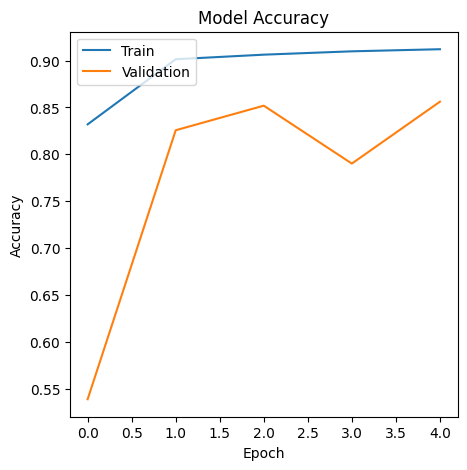

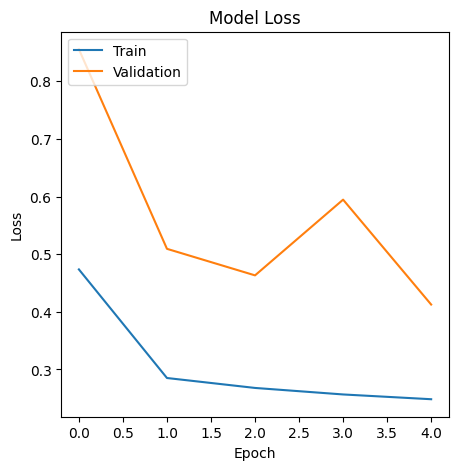

In [100]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values with smaller size
plt.figure(figsize=(5, 5))  # Kích thước nhỏ hơn
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values with smaller size
plt.figure(figsize=(5, 5))  # Kích thước nhỏ hơn
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [101]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

print(classification_report(y_test, y_pred))

1494/1494 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     42895
           1       0.40      0.92      0.56      4897

    accuracy                           0.85     47792
   macro avg       0.69      0.88      0.73     47792
weighted avg       0.93      0.85      0.87     47792



In [104]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

model.save('toxic_comment_model.h5')

In [103]:
from langdetect import detect

def clean_text_vietnamese(text):
    text = text.lower()
    text = ViTokenizer.tokenize(text)  
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.strip()

def predict_toxicity(text):
    try:
        lang = detect(text)
        is_vietnamese = lang == 'vi'
    except:
        is_vietnamese = False

    cleaned_text = clean_text(text, is_vietnamese=is_vietnamese)
    
    sequences = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    loaded_model = load_model('toxic_comment_model.h5')
    prediction = loaded_model.predict(padded_sequence)[0][0]
    
    return "Toxic Comment" if prediction >= 0.5 else "Non-Toxic Comment"

test_text = "Tao nói thật nhé, mày ngu như bò vậy"
print(predict_toxicity(test_text))
test_text = "You are such an bad person"
print(predict_toxicity(test_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Toxic Comment
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Toxic Comment
